<a href="https://colab.research.google.com/github/yvishwas40/COSC---Bayes-to-the-Future/blob/main/Bayes_to_the_Future.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip install pgmpy


Step 1: Import Libraries & Load Dataset

In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pgmpy.models import DiscreteBayesianNetwork # Corrected import
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination # Corrected import

# Load dataset
df = pd.read_csv("/content/heart_disease.csv")

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Step 2: Clean the Data

In [35]:
# Remove duplicates
df.drop_duplicates(inplace=True)

# Drop rows with missing values
df.dropna(inplace=True)

# Display numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols


['age',
 'sex',
 'cp',
 'trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal',
 'target']

 Step 3: Apply Min-Max Normalization

In [36]:
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.708333,1.0,1.000000,0.481132,0.244292,1.0,0.0,0.603053,0.0,0.370968,0.0,0.0,0.333333,1.0
1,0.166667,1.0,0.666667,0.339623,0.283105,0.0,0.5,0.885496,0.0,0.564516,0.0,0.0,0.666667,1.0
2,0.250000,0.0,0.333333,0.339623,0.178082,0.0,0.0,0.770992,0.0,0.225806,1.0,0.0,0.666667,1.0
3,0.562500,1.0,0.333333,0.245283,0.251142,0.0,0.5,0.816794,0.0,0.129032,1.0,0.0,0.666667,1.0
4,0.583333,0.0,0.000000,0.245283,0.520548,0.0,0.5,0.702290,1.0,0.096774,1.0,0.0,0.666667,1.0


In [37]:
# Discretize 'age' into bins
df['age_binned'] = pd.cut(df['age'], bins=5, labels=False, include_lowest=True)

# Drop the original continuous age column
df = df.drop('age', axis=1)

# Update numeric_cols to reflect the change
# Assuming numeric_cols is still in scope from previous cells
if 'age' in numeric_cols:
    numeric_cols.remove('age')
numeric_cols.append('age_binned')


# Define the structure with the new binned age variable
model = DiscreteBayesianNetwork([
    ('age_binned', 'fbs'), # Use the binned age
    ('fbs', 'target'),
    ('target', 'chol'),
    ('target', 'thalach')
])

# Train using Maximum Likelihood Estimation
model.fit(df, estimator=MaximumLikelihoodEstimator)

# Initialize Variable Elimination for inference
infer = VariableElimination(model)

Perform Inference with a Discretized Age Value

In [38]:
# Let's try with one of the discrete age bins, for example, bin 2
result = infer.query(
    variables=['target'],
    evidence={'age_binned': 2} # Use a discrete age bin
)
print(result)

+-------------+---------------+
| target      |   phi(target) |
+=============+===============+
| target(0.0) |        0.4579 |
+-------------+---------------+
| target(1.0) |        0.5421 |
+-------------+---------------+


Visualizing Distributions

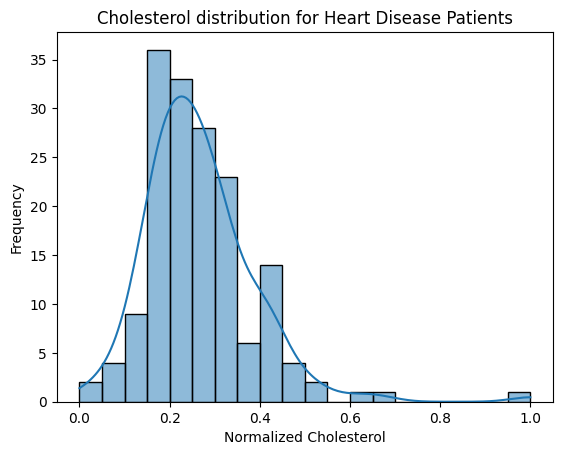

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of cholesterol for patients with heart disease
sns.histplot(df[df['target'] == 1]['chol'], bins=20, kde=True)
plt.title("Cholesterol distribution for Heart Disease Patients")
plt.xlabel("Normalized Cholesterol")
plt.ylabel("Frequency")
plt.show()
